# Using the Oxygen ML Model

In [1]:
%cd ..

/home/rehak/repos/ops/ecris.analysis


# Training the model

If you need to create a model, there is a straightforward function for doing so. 

**This can then be saved as a `pkl` file and loaded in the future instead of retraining.**

In [2]:
from ops.ecris.analysis.csd.ml import train_oxygen_model
import joblib
from pathlib import Path

MODEL_DIR = Path('./models/oxygen_nn')
model_path = MODEL_DIR / 'mlp_csd_oxygen.pkl'

training = False
save = False

if training:
    parameters = MODEL_DIR / 'mlp_csd_oxygen_params.json'
    x_path = MODEL_DIR / 'x_training.npy'
    y_path = MODEL_DIR / 'y_training.npy'
    pipeline = train_oxygen_model(parameters, x_path, y_path)
    if save:
        joblib.dump(pipeline, model_path)
    pipeline

# Using the model

Now we will load the model and a random CSD.

In [287]:
import random

from ops.ecris.analysis.io import read_csd_from_file_pair
from ops.ecris.analysis.csd import estimate_m_over_q, rescale_m_over_q
from ops.ecris.analysis.csd.ml import find_oxygen_peaks

CSD_FILEPATHS = list(Path('./data/csds').glob('csd_*'))
FILE_NUM = random.randint(0, len(CSD_FILEPATHS))
model = joblib.load(model_path)
csd_file = CSD_FILEPATHS[FILE_NUM] 
csd = read_csd_from_file_pair(csd_file)
print(f'Loaded CSD file: {csd_file}')

Loaded CSD file: data/csds/csd_1750295279


We will use the model to find the oxygen peaks and rescale M/Q. If peaks cannot be found, it will raise a `RuntimeError`.

In [288]:
csd.m_over_q = estimate_m_over_q(csd)
try:
    ml_peaks, probability = find_oxygen_peaks(csd, model)
    csd.m_over_q = rescale_m_over_q(csd.m_over_q, ml_peaks)
    print(f'Peaks found with {probability=}')
except RuntimeError as exc:
    print(f'Peaks not found, {exc}')


Peaks found with probability=0.8982225286310243


Plot the CSD and the peaks.

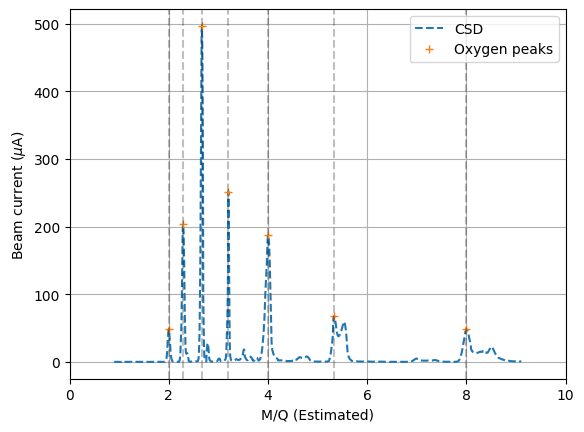

In [289]:
import matplotlib.pyplot as plt
plt.plot(csd.m_over_q, csd.beam_current, '--', label='CSD')
plt.plot(ml_peaks.m_over_q, ml_peaks.beam_current, '+', label='Oxygen peaks')
for i in range(1, 9):
    plt.axvline(16/i, ls='--', alpha=0.25, c='k')
plt.xlabel('M/Q (Estimated)')
plt.ylabel(r'Beam current ($\mu$A)')
plt.xlim([0,10])
plt.grid()
plt.legend()
plt.show()

(0.0, 300.0)

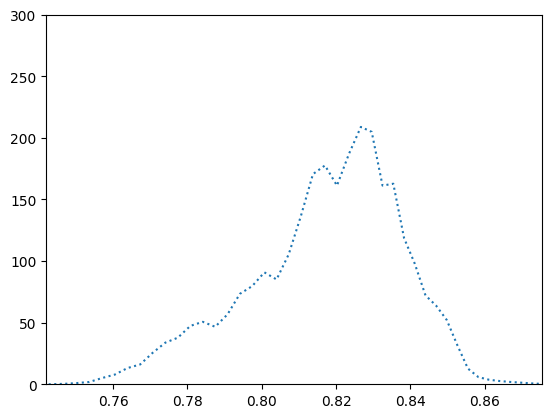

In [39]:
plt.plot(np.log(csd.m_over_q), csd.beam_current, ':')
plt.xlim([np.log(2.1), np.log(2.4)])
plt.ylim(0, 300)

[0.69314718 0.82667857 0.98082925 1.16315081 1.38629436 1.67397643
 2.07944154]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 174489.01827606274
        x: [ 7.905e-03 -9.877e-02  1.111e-01  6.988e+01  2.845e+02
             6.028e+02  1.868e+02  2.699e+02  8.644e+01  6.048e+01]
      nit: 20
      jac: [ 2.130e+01 -1.133e-01  6.250e-02  0.000e+00  0.000e+00
             0.000e+00  1.953e-03  1.953e-03  0.000e+00  0.000e+00]
 hess_inv: [[ 4.786e-10 -7.395e-08 ... -2.342e-06 -6.828e-07]
            [-7.395e-08  1.355e-05 ...  3.846e-04  1.026e-04]
            ...
            [-2.342e-06  3.846e-04 ...  8.536e-02  1.474e-03]
            [-6.828e-07  1.026e-04 ...  1.474e-03  4.971e-02]]
     nfev: 374
     njev: 34


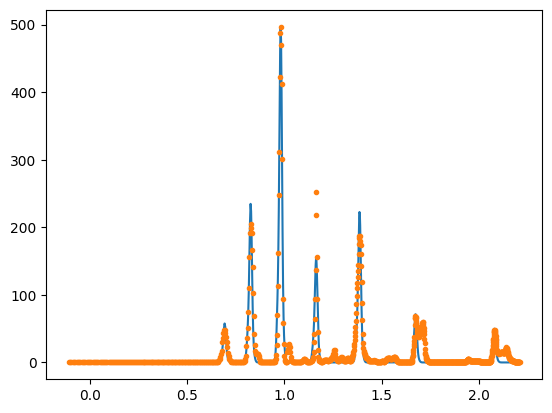

In [290]:
import numpy as np

from ops.ecris.analysis.csd import m_over_q
from scipy.optimize import minimize


means = np.log(ml_peaks.m_over_q)
print(means)

Y_0 = [0.01,  # sigma
       0.1,   # h_3
       0.1,   # h_4
] + [i for i in ml_peaks.beam_current]

X = np.log(csd.m_over_q)

def hg(X, mean, dispersion, gamma, h_3, h_4) -> float:
    w = (X - mean)/dispersion
    alpha = 1/np.sqrt(2*np.pi) * np.exp(-0.5*np.power(w, 2))
    H_0 = 1
    H_3 = 1/np.sqrt(6)*(2*np.sqrt(2)*np.power(w, 3) - 3*np.sqrt(2)*w)
    H_4 = 1/np.sqrt(24)*(4*np.power(w, 4) - 12*np.power(w, 2) + 3)
    return gamma*alpha*(np.ones_like(w) + H_0 + h_3*H_3 + h_4*H_4)

def signal(Y, means):
    sigma, h_3, h_4, beam_currents = Y[0], Y[1], Y[2], Y[3:]
    full_signal = np.zeros_like(X)
    for mean, gamma in zip(means, beam_currents):
        full_signal += hg(X, mean, sigma, gamma, h_3, h_4)
    return full_signal

def chi_squared(Y, means):
    full_signal = signal(Y, means)
    return np.sum(np.power((full_signal - csd.beam_current), 2))
from functools import partial

sol = minimize(partial(chi_squared, means=means), Y_0)
print(sol)
# hg(X)
plt.plot(X, signal(sol.x, means), '-')
plt.plot(X, csd.beam_current, '.')
# plt.xlim([np.log(2.1), np.log(2.4)])
# plt.ylim(0, 300)


In [144]:
np.linalg.norm(np.convolve(signal(sol.x), csd.beam_current))

np.float64(17845020.443189282)

In [292]:
sigma, h_3, h_4 = sol.x[0], sol.x[1], sol.x[2]

In [293]:
# Carbon
m = 12
q = 6
means = np.log([12/i for i in range(1, q)])
Y_0 = [sigma, h_3, h_4] + [100]*len(means)
sol = minimize(partial(chi_squared, means=means), Y_0)
sol.x

array([ 1.13434951e-02, -1.82280276e-01,  1.06228603e-01,  1.00000000e+02,
        9.06054574e-01,  2.31530396e+02,  4.94578872e+00,  1.33074038e+01])

In [294]:
def fit_isotope(m, q):
    means = np.flip(np.log([m/i for i in range(1, q + 1) if m/i < 10]))
    Y_0 = [sigma, h_3, h_4] + [100]*len(means)
    sol = minimize(partial(chi_squared, means=means), Y_0)
    full_signal = signal(sol.x, means)
    return sol, np.linalg.norm(np.convolve(full_signal,
                                           csd.beam_current))

In [324]:
import pandas as pd
isotopes = pd.read_csv('./data/IsotopeData.txt', names=['sym', 'Q', 'a', 'M'], usecols=range(1,5), delimiter='\t')
found_isotopes = []
for _, row in isotopes.iterrows():
    m = row['M']
    q = row['Q']
    if q > 20:
        break
    if row['a'] < 10:
        continue
    sol, cv = fit_isotope(m, q)
    heights = sol.x[3:]
    if np.all([h > 0 for h in heights]):
        found_isotopes.append((m, q, sol, cv))

In [325]:
top_isotopes = np.flip(np.argsort([f[3] for f in found_isotopes]))

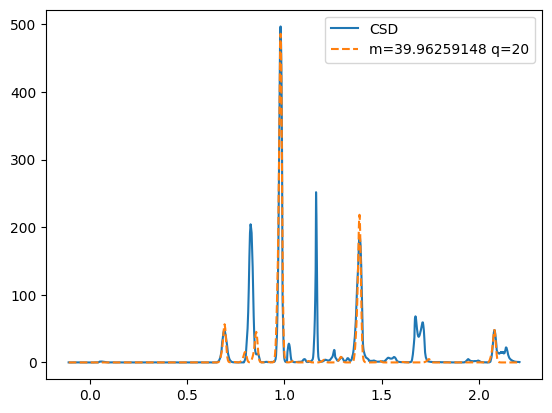

In [328]:
plt.plot(X, csd.beam_current, '-', label='CSD')
for i in top_isotopes[2:3]:
    m, q, sol, cv = found_isotopes[i]
    means = np.flip(np.log([m/i for i in range(1, q + 1) if m/i < 10]))
    plt.plot(X, signal(sol.x, means), '--', label=f'{m=} {q=}')
plt.legend()
plt.show()